# A notebook with the FRB/US model
This notebook is based on the the FRB/US model packages located here (https://www.federalreserve.gov/econres/us-models-package.htm).

This notebook and the tool used is highly experimental and the results are purely for illustration. 

You ca run each cell by pressing the run tool or shift+enter

# Import Python libraries

In [1]:
%matplotlib inline
import pandas as pd
import  ipywidgets as widgets  
from IPython.display import display, clear_output
import matplotlib.pylab  as plt 
import seaborn as sns
import qgrid 
from numba import jit

import sys
sys. path.append('modelflow/')
 
from modelsandbox import newmodel  
import modelnet as mn
import modelmf
from modelclass import ttimer


# Prepare some stuff

In [2]:
turbo = 1   # Determines if the the model is compiled or not 

# define af function which is in Eviews but not in Python
@jit("f8(b1,f8,f8)")
def recode(condition,yes,no):
    '''Function which recratetes the functionality of @recode from eviews ''' 
    return yes if condition else no

# Load the model and the data 
The model and the data has been prepared in a preprocessor step. 

In [3]:
basedf  = pd.read_pickle('frbus/data/baseline.pc')
ffrbus  = open('frbus/model/ffrbusvar.txt','rt').read() 
# print(ffrbus)

# Create a model class instance

In [4]:
mfrbus = newmodel(ffrbus,funks=[recode])

mfrbus.use_preorder = True  

This model has simultaneous elements or cyclical elements. The formulars will be evaluated in input sequence


# Show solving structure (only current year)

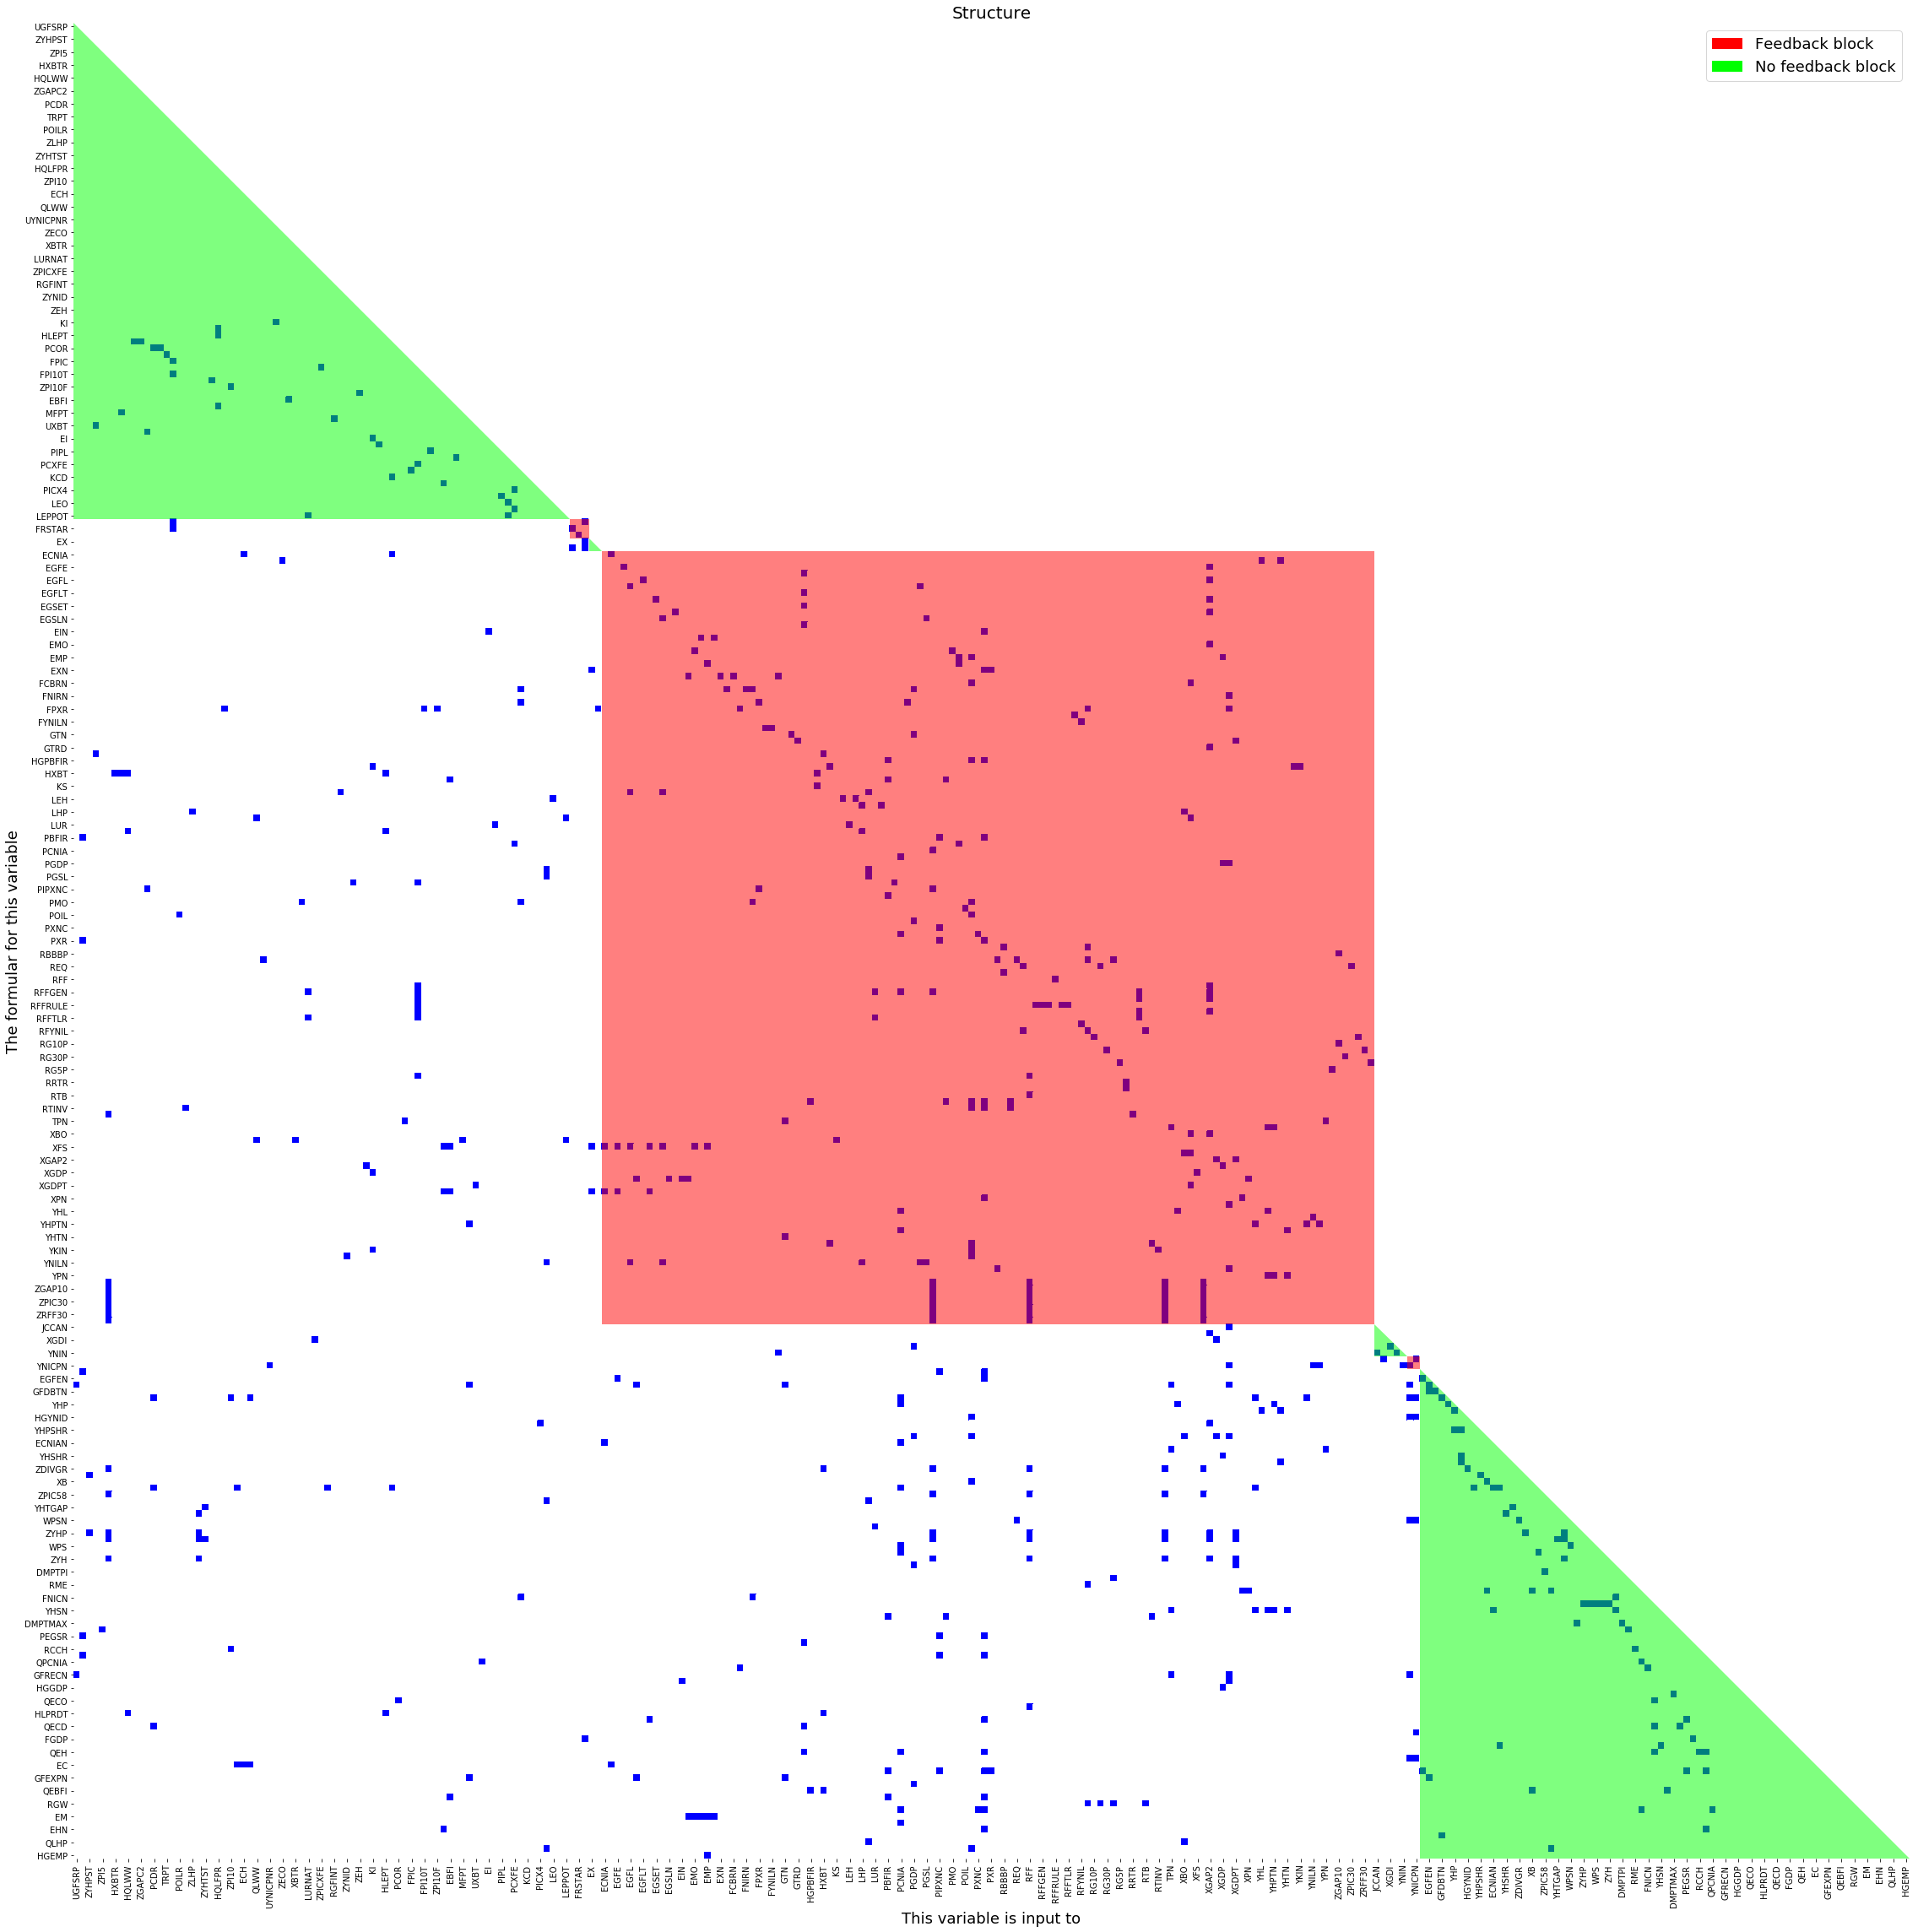

In [5]:
fig   = mn.draw_adjacency_matrix(mfrbus.endograph,mfrbus.precoreepiorder,
                                          mfrbus._superstrongblock,mfrbus._superstrongtype,size=(40,40))
fig.savefig('graph/FRB-US causality structure.pdf')

# Run Baseline

In [6]:
res = mfrbus(basedf,'2020q1','2025q4',antal= 500,relconv=0.000000001,
             conv='XGDPN',first_test=10,ldumpvar=True,ljit=turbo,silent=1,debug=0)

Compiling chunk 0      19:56:14
Compiling a mastersolver      19:56:22
Compiling chunk 0      19:56:23
Compiling a mastersolver      19:56:32
Compiling chunk 0      19:56:33
Compiling a mastersolver      19:56:37


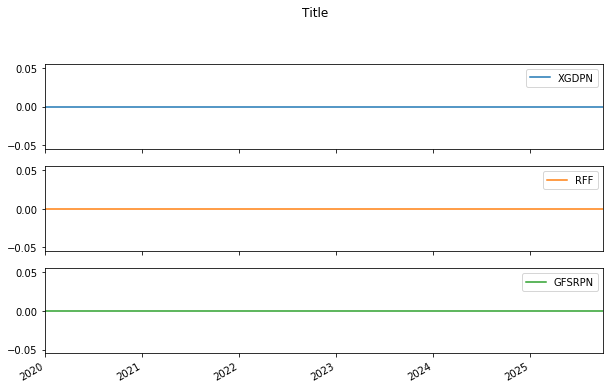

In [7]:
# just check that the baseline is close to the original solution 
_ = mfrbus['XGDPN RFF GFSRPN'].dif.plot(colrow=1,sharey=0)

# Run alternative 

In [9]:
altdf = basedf.copy()
altdf=altdf.mfcalc('''\
rffintay_aerr = rffintay_aerr - 0.01
dmpex    = 0 
dmprr    = 0
dmptay   = 0
dmptlr   = 0 
dmpintay = 1
dmpalt   = 0
dmpgen   = 0

RFFMIN = 0.0
DMPTRSH = 0
'''.upper(),silent=1)
with ttimer('Solve Frbus'):
    res2 = mfrbus(altdf,'2020q1','2025q4',sim=True,antal= 500,relconv = 0.00000001,
                     conv='XGDPN',dumpvar ='rff*',first_test=10,ldumpvar=False,ljit=turbo,silent=1,debug=0)


Solve Frbus started at :        19:56:38 
Solve Frbus took       :    0.0199999809 Seconds


In [10]:
trans = {'XGDPN':'GDP real terms (XGDPN)','RFF':'Federal Funds Rate (RFF)','GFSRPN':'Federal Budget surplus',
        'RFFMIN':'Minimum Fed Funds'}


# Show the results 

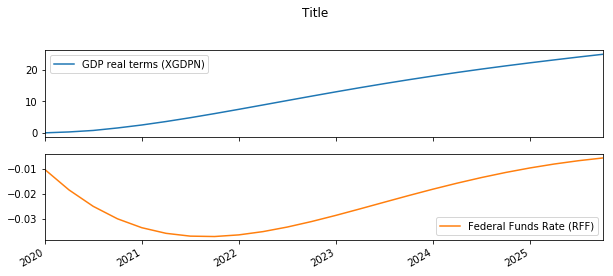

In [11]:
_ = mfrbus['XGDPN RFF'].dif.rename(trans).plot(colrow=1,sharey=0)

# Create interactive widgets 
If you are not familiar with Python and Ipywidgets, don't try to understand the code. 
Just notice that it is fairly short. 

In [12]:
# Define output widget
def vis_alt3(dfs,model,title='Show variables',basename='Baseline',altname='Alternative'):
    ''' display tabbed widget with results from different dataframes, usuallly 2 but more can be shown'''
    avar = dfs[0].columns
    outlist =     [widgets.Output() for var in avar]
    outdiflist =     [widgets.Output() for var in avar]    
    deplist =     [widgets.Output() for var in avar]
    reslist =     [widgets.Output() for var in avar]
    attlist =     [widgets.Output() for var in avar]
    varouttablist =  [widgets.Tab(children = [out,outdif,att,dep,res]) 
                      for out,outdif,att,dep,res  in zip(outlist,outdiflist,attlist,deplist,reslist)]
    for var,varouttab in zip(avar,varouttablist):
        for i,tabtext in enumerate(['Level','Change','Attribution','Dependencies','Results']):
            varouttab.set_title(i,tabtext)

    controllist = [widgets.VBox([varouttab]) for varouttab in varouttablist]
    tab = widgets.Tab(children = controllist)
    for i,(var,out) in enumerate(zip(avar,controllist)):
        tab.set_title(i, var) 
    
    def test1(b):
        sel = b['new']
        out = outlist[sel]
        outdif = outdiflist[sel]
        dep = deplist[sel]
        res = reslist[sel]
        att = attlist[sel]
        var = avar[sel]
        with out:
            clear_output()
            fig,ax = plt.subplots(figsize=(10,6))
            ax.set_title(var,fontsize=14)
            for i,df in enumerate(dfs):
                data = df.loc[:,var]
                data.plot(ax=ax,legend=False,fontsize=14)
                x_pos = data.index[-1]
                if i == 0:
                    basevalue = data.values[-1]
                else:
                    alt=i if len(dfs) >= 3 else ''
                    if abs(data.values[-1]-basevalue) > 0.01:
                        ax.text(x_pos, data.values[-1]  ,f' {altname}{alt}',fontsize=14)
                        if i == 1:
                            ax.text(x_pos, basevalue  ,f' {basename}',fontsize=14)
                    else:
                        ax.text(x_pos, data.values[-1]  ,f' {basename} and {altname}{alt}',fontsize=14)
            plt.show(fig)
        with outdif:
            clear_output()
            fig,ax = plt.subplots(figsize=(10,6))
            ax.set_title(var,fontsize=14)
            for i,df in enumerate(dfs):
                if i == 0:
                    basedata = df.loc[:,var]
                    x_pos = data.index[-1]
                else:
                    data = df.loc[:,var]-basedata
                    data.plot(ax=ax,legend=False,fontsize=14)
                    x_pos = data.index[-1]
                    alt=i if len(dfs) >= 3 else ''
                    ax.text(x_pos, data.values[-1]  ,f' Impact of {altname}{alt}',fontsize=14)
            plt.show(fig)
        with dep:
            clear_output()
            model.draw(var,up=2,down=2,svg=1)
        with res:
            clear_output()
            print(model.get_values(var).T.rename(columns={'Base':basename,'Last':altname}))
        with att:
            clear_output()
            #model.smpl(N-20,N)
            if var in model.endogene:
                print(f'What explains the difference between the {basename} and the {altname} run ')
                print(model.allvar[var]['frml'])
                model.explain(var,up=0,dec=1,size=(9,12),svg=1,HR=0)
            else:
                print(f'{var} is exogeneous and attribution can not be performed')
            
    display(tab) 

    test1({'new':0})
    tab.observe(test1,'selected_index')
    return tab

# Define data extraction
def get_alt(mmodel,pat):
    ''' Retrieves variables matching pat from a model '''
    varnames = mmodel.vlist(pat)
    modelvar = mmodel.exogene | mmodel.endogene
    modelvarnames = [v for v in varnames if v in modelvar]
    per = mmodel.current_per
    return [mmodel.basedf.loc[per,varnames],mmodel.lastdf.loc[per,varnames]]

#a = vis_alt3(get_alt(mfrbus,['RFF XGDPN RFFMIN GFSRPN']),mfrbus)


# Create interactive input widget

In [13]:
# Define the imput widget 
def inputwidget(model,df,wdef,radiodef,checkdef,varpat='RFF XGDPN RFFMIN GFSRPN DMPTRSH XXIBDUMMY',showout=1):
    '''Creates an input widgets for updating variables 
    
    :df: Baseline dataframe 
    :wdef: dict with definition of variables to be updated by slider
    :radiodef: dict of dic. each at first level defines a collection of radiobuttoms
               second level defines the text for each leved and the variable to set or reset to 0
    :varpat: the variables to show in the output widget
    :showout: 1 if the output widget is to be called '''
    
    wradiolist = [widgets.RadioButtons(options=cont['options'],description=des,layout={'width':'70%'},
                                       style={'description_width':'37%'}) for des,cont in radiodef.items()]
    basename ='Baseline'
    if len(wradiolist) <=2:
        wradio = widgets.HBox(wradiolist)
    else: 
        wradio = widgets.VBox(wradiolist)

            
    wexp  = widgets.Label(value="Input new parameter ",layout={'width':'41%'})
    walt  =  widgets.Label(value="Alternative",layout={'width':'8%'})
    wbas  =  widgets.Label(value="Baseline",layout={'width':'8%'})
    whead = widgets.HBox([wexp,walt,wbas])
    
    wset  = [widgets.FloatSlider(description=var,min=min,max=max,value=value,step=0.01,
                                layout={'width':'50%'},style={'description_width':'30%'})
             for var,(value,min,max) in wdef.items()]
    waltval= [widgets.Label(value=f"{wdef[var][0]:>.2f}",layout={'width':'8%'})
              for var,(value,min,max)  in wdef.items()]
    wline = [widgets.HBox([s,v]) for s,v in zip(wset,waltval)]
    
    wchecklist = [widgets.Checkbox(description=des,value=val)   for des,var,val in checkdef]
    wcheck  = widgets.HBox(wchecklist)   
    
    wname = widgets.Text(value='Alternative',placeholder='Type something',description='Name of experiment:',
                        layout={'width':'30%'},style={'description_width':'50%'})
    wpat = widgets.Text(value=varpat,placeholder='Type something',description='Output variables:',
                        layout={'width':'65%'},style={'description_width':'30%'})
    winputstring = widgets.HBox([wname,wpat])
    
    wgo   = widgets.Button(description="Run")
    wreset   = widgets.Button(description="Reset to default")
    wsetbas   = widgets.Button(description="Use as baseline")
    wbut  = widgets.HBox([wgo,wreset,wsetbas])
    w     = widgets.VBox([whead]+wline+[wradio] + [wcheck] +[winputstring] +[wbut])

    # This function is run when the button is clecked 
    def run(b):
        mulstart       = df.copy()
        
        # First update from the sliders 
        for i,var in enumerate(wdef.keys()):
            avar = var+'_AERR'
            if avar in mulstart.columns:
                mulstart.loc[model.current_per,avar] =  mulstart.loc[model.current_per,avar] + wset[i].value
            else:    
                mulstart.loc[model.current_per,var] =   wset[i].value
                
        # now  update from the radio buttons 
        for wradio,(des,cont) in zip(wradiolist,radiodef.items()):
            print(des,wradio.value,wradio.index,cont['vars'][wradio.index])
            for v in cont['vars']:
                mulstart.loc[model.current_per,v] = 0.0
            mulstart.loc[model.current_per,cont['vars'][wradio.index]] = 1.0  
            
        for box,(des,var,_) in zip(wchecklist,checkdef):
            mulstart.loc[model.current_per,var] = 1.0 * box.value

        #with out:
        clear_output()
        mul = model(mulstart,'2020q1','2025q4',sim=True,antal= 500,relconv = 0.00000001,
             conv='XGDPN',dumpvar ='rff*',first_test=10,ldumpvar=False,ljit=turbo,silent=0,debug=0)

        clear_output()
        display(w)
        #_ = mfrbus['XGDPN RFF RFFMIN GFSRPN'].dif.rename(trans).plot(colrow=1,sharey=0)
        if showout:
            a = vis_alt3(get_alt(model,wpat.value),model,basename=basename,altname=wname.value)

    def reset(b):
        for i,var in enumerate(wdef.keys()):
            wset[i].value  =   wdef[var][0]
            
        for wradio in wradiolist:
            wradio.index = 0
            
        for box,(des,var,defvalue) in zip(wchecklist,checkdef):
            box.value = defvalue

    def setbas(b):
        nonlocal basename
        model.basedf = model.lastdf.copy(deep=True)
        basename = wname.value
        
    # Assign the function to the button  
    wgo.on_click(run)
    wreset.on_click(reset)
    wsetbas.on_click(setbas)
    out = widgets.Output()
    
    return w


wdef={'RFFINTAY':[0.0,-3,3],'RFFMIN':[0.0,-20,5]}
radiodef = {'Monetary policy reaction':{
            'options'  :['Inertial Taylor rule','Taylor rule','Taylor rule with unemployment gap','Estimated rule','Generalized rule','Exogenous nominal funds rate','Exogenous real funds rate'],
            'vars'     :['DMPINTAY',            'DMPTAY','DMPTLR'                               , 'DMPALT',        'DMPGEN',          'DMPEX',                        'DMPRR']
}}
           
checkdef = [('Timing of zero lower bound', 'DMPTRSH' ,True) ]

input = inputwidget(mfrbus,basedf,wdef=wdef,radiodef={**radiodef},checkdef=checkdef,showout=True,
                    varpat='RFF XGDPN RFFMIN GFSRPN DMPTRSH')

# Now go 

In [14]:
display(input)

# Some interfaces 
. (dot) makes it easy to look at single variable. 

\[ \] (Slice) alows inspection of many variables selected with wildcars

In [15]:
 # we only want a few quarters 
_ = mfrbus.smpl('2020q1','2021q1')

# How is the interest rate determined

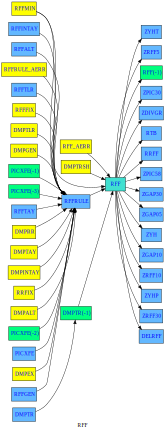

In [16]:
mfrbus.RFF.draw(up=2,down=1,HR=0,svg=1)

In [17]:
mfrbus.rff.show

Endogeneous: RFF 
Formular: FRML  <> RFF=(1-DMPTRSH)*(RECODE((RFFRULE)>(RFFMIN),RFFRULE,RFFMIN))+DMPTRSH*(RECODE(((DMPTR(-1)*RFFRULE+(1-DMPTR(-1))*RFFMIN))>(RFFMIN),(DMPTR(-1)*RFFRULE+(1-DMPTR(-1))*RFFMIN),RFFMIN))+RFF_AERR  $
Values : 
        2020Q1    2020Q2    2020Q3    2020Q4    2021Q1
Base  3.153624  3.250023  3.324873  3.378474  3.411382
Last  3.143625  3.231768  3.299996  3.348576  3.377909
Diff -0.009999 -0.018255 -0.024878 -0.029899 -0.033472

Input last run: 
                  2020Q1        2020Q2        2020Q3        2020Q4  \
DMPTR(-1)  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
DMPTRSH    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
RFFMIN     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
RFFRULE    3.143622e+00  3.231768e+00  3.299997e+00  3.348578e+00   
RFF_AERR  -6.833184e-17 -6.833184e-17 -6.833184e-17 -6.833184e-17   

                 2021Q1  
DMPTR(-1)  1.000000e+00  
DMPTRSH    0.000000e+00  
RFFMIN     0.000000e+00  
RFFRU

In [18]:
_= mfrbus.rffintay.dekomp(start='2020q1',end='2021q1')

Formula        : FRML  <> RFFINTAY=.85*RFF(-1)+(1-.85)*(RSTAR+(PICXFE+PICXFE(-1)+PICXFE(-2)+PICXFE(-3))/4+0.5*((PICXFE+PICXFE(-1)+PICXFE(-2)+PICXFE(-3))/4-PITARG)+1.0*XGAP2)+RFFINTAY_AERR  $ 

                    2020Q1     2020Q2     2020Q3     2020Q4     2021Q1
Variable    lag                                                       
Base        0     3.153624   3.250023   3.324873   3.378474   3.411382
Alternative 0     3.143622   3.231768   3.299997   3.348578   3.377909
Difference  0    -0.010002  -0.018255  -0.024877  -0.029897  -0.033472
Percent     0    -0.317149  -0.561694  -0.748203  -0.884922  -0.981199

 Contributions to differende for  RFFINTAY
                      2020Q1     2020Q2     2020Q3     2020Q4     2021Q1
Variable      lag                                                       
RFF           -1    0.000001  -0.008500  -0.015517  -0.021146  -0.025414
RSTAR          0    0.000001  -0.000000  -0.000000  -0.000000  -0.000000
PICXFE         0    0.000001   0.000005   0.0

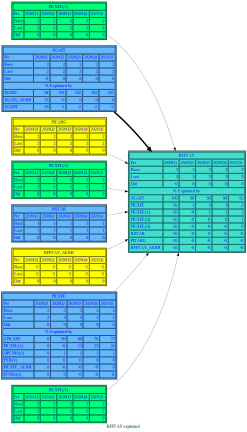

In [19]:
_ = mfrbus.rfftay.explain(up=1,svg=1,pdf=0)

In [20]:
mfrbus['rffta* rffrule*']

          RFFTAY  RFFTAY_AERR   RFFRULE  RFFRULE_AERR
2020Q1  3.096484    -1.960046  3.143622  2.400000e-10
2020Q2  3.087531    -1.960046  3.231768  3.550000e-09
2020Q3  3.060563    -1.960046  3.299997 -5.000007e-11
2020Q4  3.016362    -1.960046  3.348578 -1.900001e-10
2021Q1  2.962290    -1.960046  3.377909 -5.300001e-10

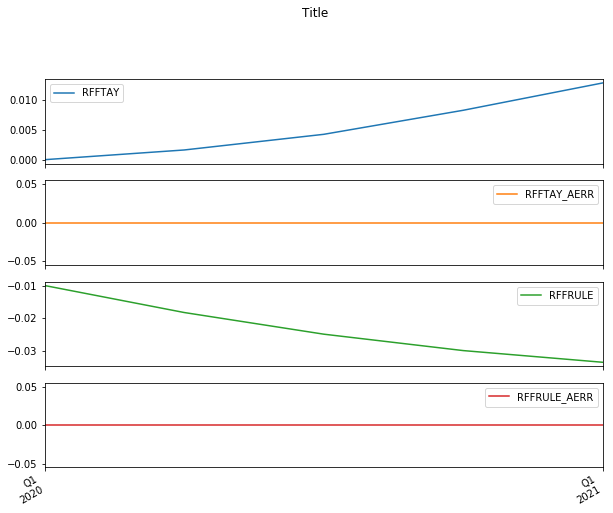

In [21]:
_ = mfrbus['rffta* rffrule*'].dif.plot(colrow=1,sharey=0)

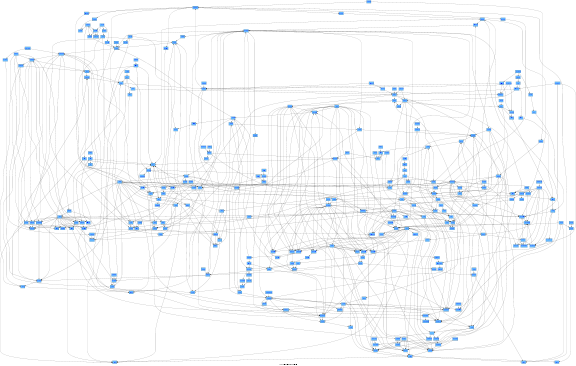

In [22]:
mfrbus.drawendo(lag=0,title='FRB/US endogeneous interpendencies',pdf=0)
# you will find the output files in different format in the /graph folder